In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import pip
pip.main(['install','seaborn'])
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import DenseNet121, VGG19
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, LeakyReLU, GlobalAveragePooling2D, Conv2D, Input
from keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

modelclass = '3'
suffix = 'FIN'
iterations = 5
iterations2 = 5

def CreateModel(learn_rate):
    input_tensor = Input(shape=(256, 256, 3))
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    for layer in base_model.layers[:10]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(negative_slope=0.01)(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learn_rate),
                  loss=BinaryFocalCrossentropy(),
                  metrics=['accuracy'])

    return model

base_dir = '../../Data/Arrays/'
class_dir = 'Converted Arrays/'
train_images = np.load(os.path.join(base_dir, 'train_images.npy'))
train_labels = np.load(os.path.join(class_dir, f'train_labels_class{modelclass}.npy'))
val_images = np.load(os.path.join(base_dir, 'val_images.npy'))
val_labels = np.load(os.path.join(class_dir, f'val_labels_class{modelclass}.npy'))

if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, axis=-1)
    train_images = np.repeat(train_images, 3, axis=-1)

if len(val_images.shape) == 3:
    val_images = np.expand_dims(val_images, axis=-1)
    val_images = np.repeat(val_images, 3, axis=-1)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels.flatten())
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

print("Initial class weights:", class_weights)
print("Start time: ", datetime.datetime.now())

best_model_path = f'Models/class{suffix}{modelclass}temp.keras'
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

best_val_loss = float('inf')
for i in range(iterations):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-7)
    model = CreateModel(1e-5)
    print(f"Training iteration {i+1}/{iterations}")
    history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size=16,
                        validation_data=(val_images, val_labels),
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    model.load_weights(best_model_path)
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Best current val:{best_val_loss}")
        model.save(f'Models/class_{suffix}{modelclass}_overallbest.keras')

print("Training Complete")

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: seaborn in /opt/conda/lib/python3.11/site-packages (0.13.2)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /opt/conda/lib/python3.11/site-packages (from seaborn) (1.26.4)

Requirement already satisfied: pandas>=1.2 in /opt/conda/lib/python3.11/site-packages (from seaborn) (2.2.3)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /opt/conda/lib/python3.11/site-packages (from seaborn) (3.9.3)

Requirement already satisfied: contourpy>=1.0.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.3.1)

Requirement already satisfied: cycler>=0.10 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)

Requirement already satisfied: fonttools>=4.22.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.55.3)

Requirement already satisfied: kiwisolver>=1.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.4.7)

Requirement already satisfied: packaging>=20.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (24.2)

Requirement already satisfied: pillow>=8 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (10.4.0)

Requirement already satisfied: pyparsing>=2.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (3.2.0)

Requirement already satisfied: python-dateutil>=2.7 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (2.9.0.post0)

Requirement already satisfied: pytz>=2020.1 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2023.3)

Requirement already satisfied: tzdata>=2022.7 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2024.2)

Requirement already satisfied: six>=1.5 in /opt/conda/lib/python3.11/site-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.4->seaborn) (1.17.0)

Initial class weights: {0: 0.6914243830930857, 1: 1.8059987236758137}
Start time:  2025-01-16 09:07:53.604476


I0000 00:00:1737018473.768483    2024 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737018473.822181    2024 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737018473.825585    2024 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737018473.829877    2024 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Training iteration 1/5
Epoch 1/50


I0000 00:00:1737018484.667144    2072 service.cc:146] XLA service 0x7f409c0042b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737018484.667174    2072 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


  1/354 ━━━━━━━━━━━━━━━━━━━━ 2:02:14 21s/step - accuracy: 0.2500 - loss: 0.3728

I0000 00:00:1737018502.540278    2072 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4849 - loss: 0.1982

E0000 00:00:1737018574.055647    2073 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737018574.277330    2073 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


354/354 ━━━━━━━━━━━━━━━━━━━━ 116s 270ms/step - accuracy: 0.4850 - loss: 0.1981 - val_accuracy: 0.7473 - val_loss: 0.1713 - learning_rate: 1.0000e-05
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.5448 - loss: 0.1727 - val_accuracy: 0.4761 - val_loss: 0.1734 - learning_rate: 1.0000e-05
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.5741 - loss: 0.1725 - val_accuracy: 0.3304 - val_loss: 0.1736 - learning_rate: 1.0000e-05
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.4819 - loss: 0.1724 - val_accuracy: 0.5336 - val_loss: 0.1731 - learning_rate: 3.0000e-06
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.5949 - loss: 0.1723 - val_accuracy: 0.3604 - val_loss: 0.1758 - learning_rate: 3.0000e-06
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.4787 - loss: 0.1720 - val_accuracy: 0.5194 - val_loss: 0.1735 - learning_rate: 9.0000e-07
Best current val:0.1713111698627472
Training iteration 2

In [2]:
best_model_path = f'Models/class{suffix}secondary{modelclass}temp.keras'
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')
best_val_loss = float('inf')
for i in range (iterations2):
    model = CreateModel(1e-7)
    model.load_weights(f'Models/class_{suffix}{modelclass}_overallbest.keras')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8)
    
    print(f"Training iteration {i+1}/{iterations2}")
    history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size=16,
                        validation_data=(val_images, val_labels),
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])

    model.load_weights(best_model_path)
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Best last val:{val_loss}")
        print(f"Best current val:{best_val_loss}")
        model.save(f'Models/class_{suffix}{modelclass}_overallbestFIN.keras')

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training iteration 1/5
Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - accuracy: 0.6310 - loss: 0.1758 - val_accuracy: 0.7226 - val_loss: 0.1660 - learning_rate: 1.0000e-07
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.6460 - loss: 0.1729 - val_accuracy: 0.7164 - val_loss: 0.1677 - learning_rate: 1.0000e-07
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.6399 - loss: 0.1733 - val_accuracy: 0.7120 - val_loss: 0.1692 - learning_rate: 1.0000e-07
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.6354 - loss: 0.1740 - val_accuracy: 0.7102 - val_loss: 0.1696 - learning_rate: 1.0000e-07
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.6298 - loss: 0.1751 - val_accuracy: 0.7085 - val_loss: 0.1697 - learning_rate: 1.0000e-08
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 74s 208ms/step - accuracy: 0.6361 - loss: 0.1741 - val_accuracy: 0.7085 - val_loss: 0.1698 - learning_rate: 1.0000e-08
Best last val:0.1660308

24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 585ms/step - accuracy: 0.7048 - loss: 0.1675
Test Loss: 0.16798102855682373
Test Accuracy: 0.6913907527923584
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step


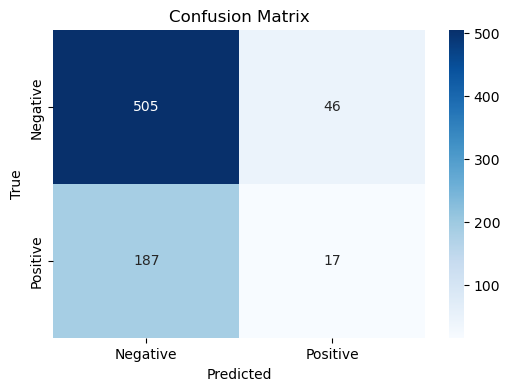

E0000 00:00:1737024845.922715    2071 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737024846.119779    2071 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


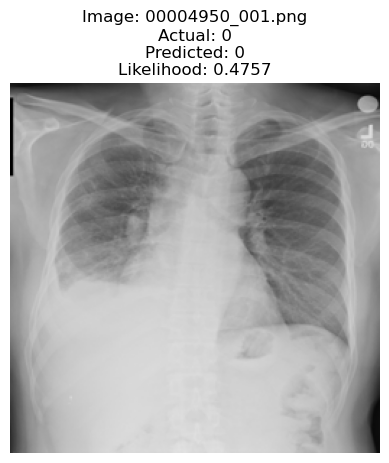

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


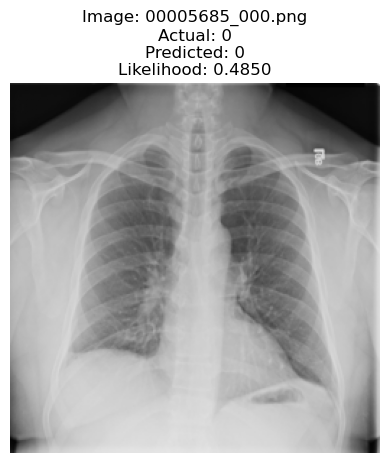

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


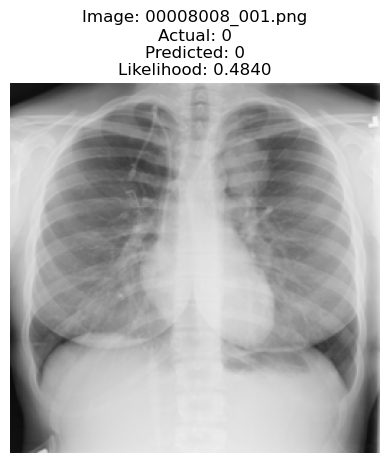

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


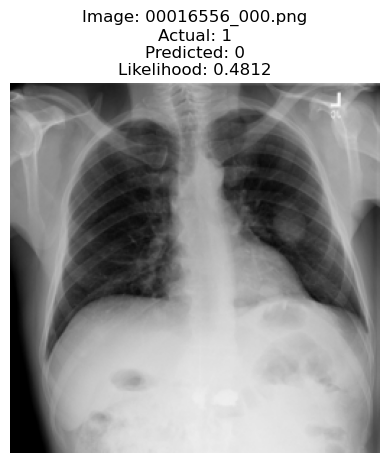

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


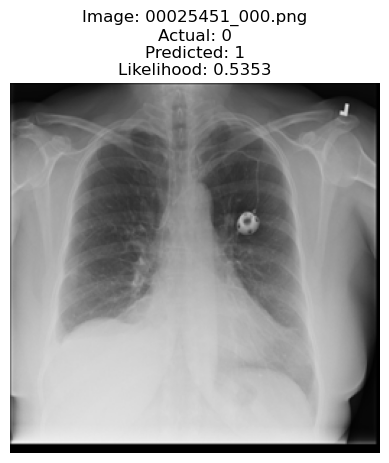

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


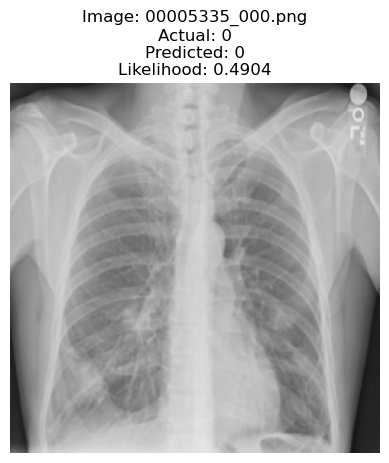

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


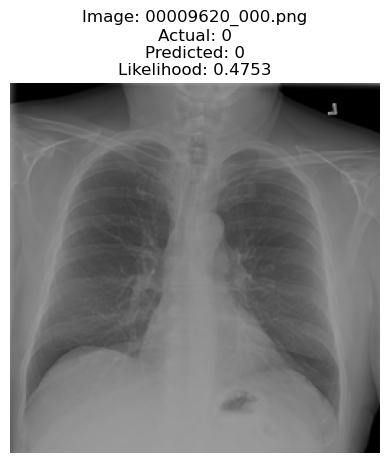

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


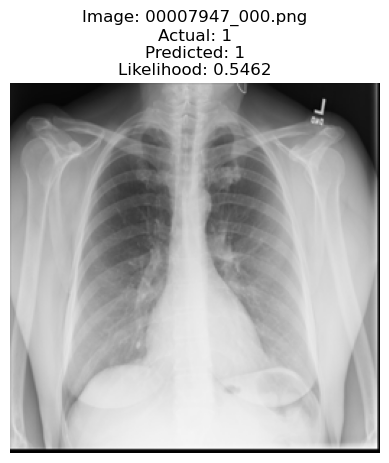

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


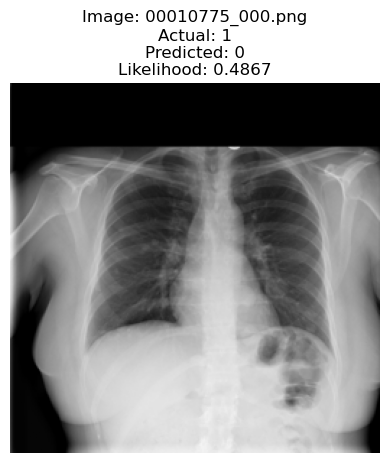

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


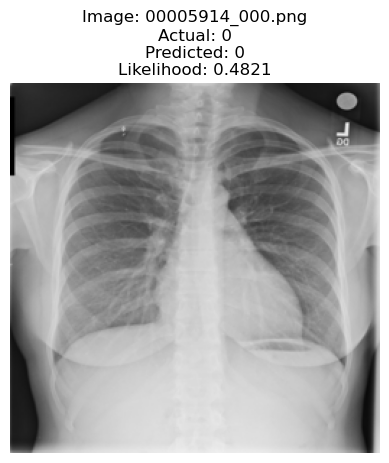

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


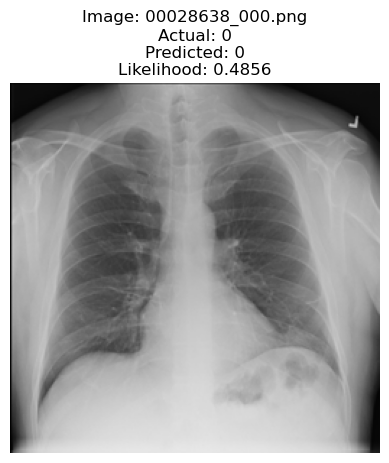

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


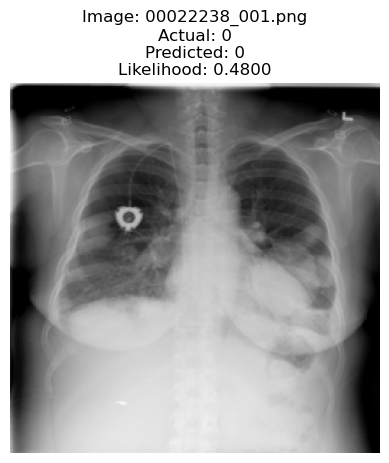

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


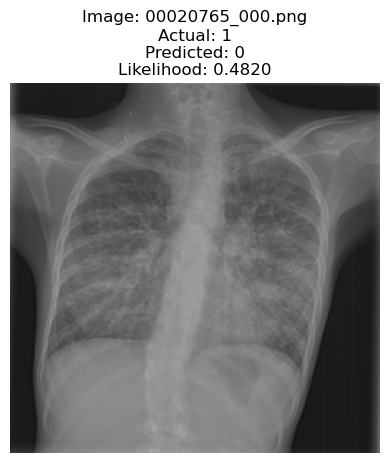

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


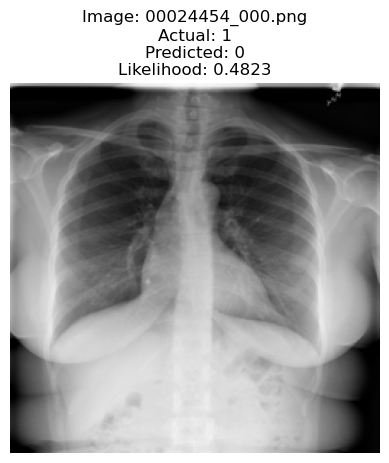

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


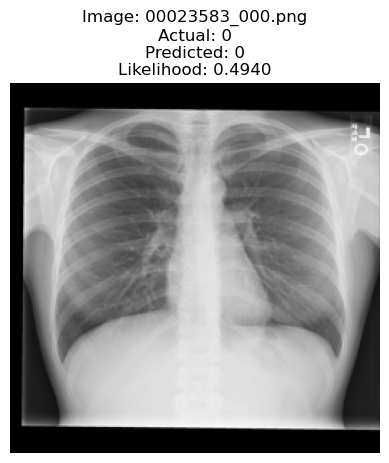

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


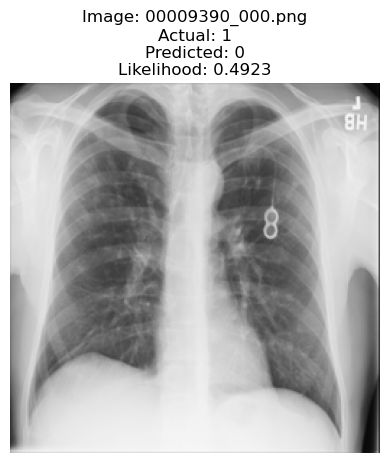

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


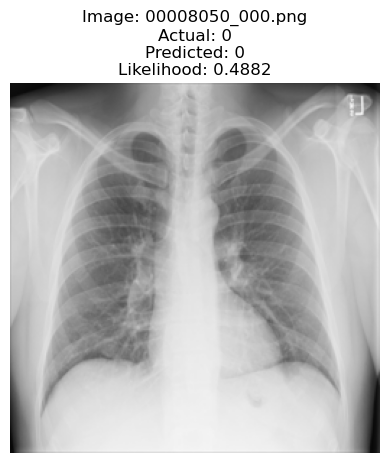

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


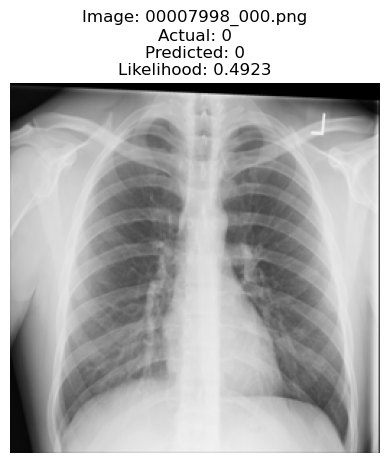

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


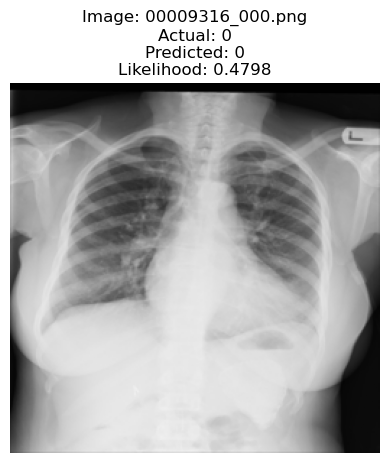

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


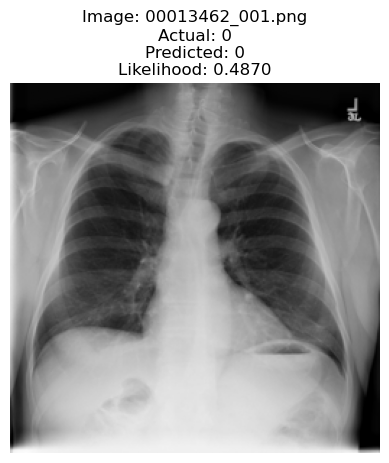

In [3]:

test_images = np.load(os.path.join(base_dir, 'test_images.npy'))
test_labels = np.load(os.path.join(class_dir, f'test_labels_class{modelclass}.npy'))
test_image_names = np.load(os.path.join(base_dir, 'test_image_names.npy'), allow_pickle=True)

if len(test_images.shape) == 3:
    test_images = np.expand_dims(test_images, axis=-1)
    test_images = np.repeat(test_images, 3, axis=-1)

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

def display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Image: {image_name}\nActual: {actual_label}\nPredicted: {predicted_label}\nLikelihood: {likelihood:.4f}")
    plt.axis('off')
    plt.show()

num_samples = 20
indices = random.sample(range(test_images.shape[0]), num_samples)

for idx in indices:
    image = test_images[idx]
    image_name = test_image_names[idx]
    actual_label = test_labels[idx][0]
    image_expanded = np.expand_dims(image, axis=0)
    prediction = model.predict(image_expanded)[0][0]
    
    threshold = 0.5
    predicted_label = int(prediction > threshold)
    likelihood = prediction
    
    display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood)